# Phys 581 Winter 2019
# Assignment #3: Data fitting
## Alexander Hickey, 10169582

In [1]:
#Import useful libraries
import numpy as np
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

### Introduction

Data sets not only allow researchers to understand phenomena, but they also allow them to test and develop models to make predictions. Loosely speaking, better models will better fit experimental data. In general, one makes the measurement of some value $Y$ after fixing some set of independent variables $X_1,X_2,...,X_n$. A model of the quantity $Y$ is a function $\hat Y(X_1,X_2,...,X_n)$ that aims to predict the outcome of some measurement, given the control parameters. Usually, the model function is written in terms of various unknown parameters, and these parameters are found by minimizing some kind of loss function. This leaves the development of a model to a good guess of the functional form, which can sometimes be inferred. For a collection of measurements $\{Y_i\}$, the standard choice for a loss function is the so-called $\chi^2$ value, given by 

$$\chi^2 = \sum_i \left(Y_i - \hat Y_i \right)^2.$$

For example, in a linear regression, one fits a function of the form $\hat Y = \beta_0 +\beta_1 X$ by minimizing the $\chi^2$ function with respect to $\beta_0$ and $\beta_1$. 


In this notebook, I will examine the solar wind data found in: http://spdf.gsfc.nasa.gov/pub/data/omni/00readme.txt, by fitting the AE index data using regressional analysis under various models. In this case, the independent variables of interes will be the magnetic field components $\vec B$, and the velocity $\vec v$. I begin by loading the data file of interest, and plotting the AE index as a function of the z-component of $\vec B$.

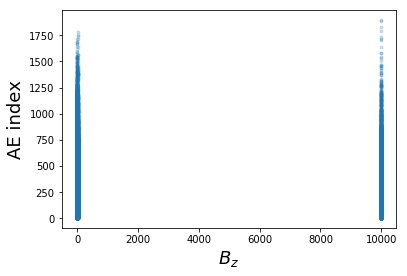

In [2]:
data = np.load('omni_1min_2014.npy')

plt.plot( data['bz'], data['ae_index'], '.', alpha=0.2 )
plt.xlabel('$B_z$',fontsize=18)
plt.ylabel('AE index',fontsize=18)
plt.show()

Browsing through the documentation for the data here: https://spdf.gsfc.nasa.gov/pub/data/omni/00readme.txt, we see that the records corresponding to missed data are set to 9999. We must therefore truncate the data set to include only the "physically relevant" data points. Additionally, it is a good idea to "standardize" the data set (i.e. shift to mean 0 and normalize standard deviation), to effectively make the data dimensionless, allowing us to work with numbers of order $1$.

In [3]:
dtype = np.dtype([ ('min', np.double), ('max', np.double), 
                  ('mean', np.double), ('stdev', np.double)])
process = {}

#Record range of interest for each data set
process['bz'] = process['bx'] = process['by'] = np.array([(-29,
                                                           +29, np.nan, np.nan)], dtype=dtype)
process['vx'] = process['vy'] = process['vz'] = np.array([(-2100,
                                                           +50.0, np.nan, np.nan)], dtype=dtype)
process['ae_index'] = np.array([(-100, +2999, np.nan, np.nan)], dtype=dtype) 

#Truncate data to be in the acceptable range
alltrue = np.ones( len(data), dtype=np.bool )
for name in process:
    p = process[name]
    wgood = (data[name] >= p['min']) & (data[name] <= p['max'])
    alltrue = alltrue & wgood   

#Generate standardized data set by shifting to mean and scaling by standard deviation
newdat = {}
for name in process:
    
    #Take only data in acceptable range
    p = process[name]
    dat = data[name][alltrue].astype(np.double)
    
    #Standardize
    p['mean'] = np.mean( dat )
    p['stdev'] = np.std( dat )
    dat = ( dat - p['mean'] ) / p['stdev']
    
    newdat[name] = dat
    
#Isolate AE index data and leave independent variables in dict
AE = newdat.pop('ae_index')
xfit = newdat.copy()

Plotting the standardized data, we see that the data is more or less grouped togethor and of order 1.

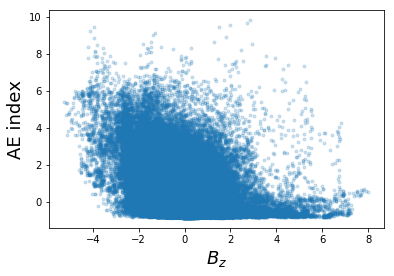

In [4]:
plt.plot( xfit['bz'], AE,'.', alpha=.2)
plt.xlabel('$B_z$',fontsize=18)
plt.ylabel('AE index',fontsize=18)
plt.show()

#### Tasks:

Use tools in scipy.optimize (or elsewhere) to fit a linear model with a single variable 

 $$ AE = c_1 B_z $$

by finding the value of $c_1$ which minimizes the goodness of fit given by 

 $$ \chi^2 = \sum (\mathrm{model} - \mathrm{data})^2 $$

then try two variables

 $$ AE = c_1 B_z + c_2 v_x $$
 
then try a non-linear transformation of a single variable
 
 $$ AE = c_1 B_z + c_2 v_x^2 $$ 
 
then try cross terms 

 $$ AE = c_1 B_z + c_2 v_x + c_3 B_z v_x $$ 
 
then explore combinations and transformations of variables to obtain "the best" model.  Think about what that means.

The following block defines the chi2 value for an arbitrary model choice, followed by the various models listed above.

In [5]:
def chi2(param, x, y, model):
    ''' 
    Computes the deviation of a model from a data set, rescaled by
    the length of the data set. This function will be called by an
    optimizer to determine the 'best fit' parameters of a given model.
    
    Args:
        param: array, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        y: array of data to be fit
        model: function, defines which model to fit the data with
        
    Return:
        chi2: Normalized chi-squared value of the model.
    '''
    
    dy = y - model(param, x)
    
    return np.sum(dy**2) / len(y)

def model_1(param, x):
    '''
    Linear, single coefficient model: y = c0*bz
    
    Args:
        param: array of length 1, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y =  x['bz'] * param[0]
    
    return y

def model_2(param, x):
    '''
    Linear, two coefficient model: y = c0*bz + c1
    
    Args:
        param: array of length 2, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + x['bz'] * param[1]
    
    return y


def model_3(param, x):
    '''
    Two-variable model: y = c0 + c1*bz + c2*vx
    
    Args:
        param: array of length 3, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + param[1]*x['bz'] + param[2] * x['vx']
    
    return y


def model_4(param, x):
    '''
    Two-variable quadratic model: y = c0 + c1*bz + c2*vx^2
    
    Args:
        param: array of length 3, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + param[1]*x['bz'] + param[2] * x['vx']*x['vx']
    
    return y

def model_5(param, x):
    '''
    Two-variable cross-term model: y = c0 + c1*bz + c2*vx + c3*bz*vx
    
    Args:
        param: array of length 4, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + param[1]*x['bz']+ param[2]*x['vx'] + param[3]*x['bz']*x['vx']
    
    return y

The best fit parameters for each model is the determined by minimizing the $\chi^2$ value. In this case, the optimization is carried out using the scipy.optimize.minimize method, calling the Nelder-Mead algorithm

In [6]:
guess, res = np.ones(4), np.zeros(5)

res[0] = scipy.optimize.minimize(chi2, guess[:1], (xfit, AE,model_1),
                                 method='Nelder-Mead' )['fun']
res[1] = scipy.optimize.minimize(chi2, guess[:2], (xfit, AE,model_2),
                                 method='Nelder-Mead' )['fun']
res[2] = scipy.optimize.minimize(chi2, guess[:3], (xfit, AE,model_3),
                                 method='Nelder-Mead' )['fun']
res[3] = scipy.optimize.minimize(chi2, guess[:3], (xfit, AE,model_4),
                                 method='Nelder-Mead' )['fun']
res[4] = scipy.optimize.minimize(chi2, guess[:4], (xfit, AE,model_5),
                                 method='Nelder-Mead' )['fun']

for k in range(len(res)):
    print('Model '+str(k+1)+', chi^2 = '+str(res[k]))

Model 1, chi^2 = 0.8546207607221559
Model 2, chi^2 = 0.8546207602546695
Model 3, chi^2 = 0.8062733303281352
Model 4, chi^2 = 0.83726628954218
Model 5, chi^2 = 0.8049258495723541


Interestingly, the $\chi^2$ value is minimized by the model with a cross-term in $B_z$ and $v_x$, suggesting that the cross term itself plays some role in determing the AE index. Additionally, we see that the models with quadratic terms lead to significantly better fits than those which are just linear. Although the $\chi^2$ numbers seem quite similar, an approximately $5 \%$ reduction is quite significant, given the size of the data set.

With these in consideration, we can look at a more complicated model. This model takes the cross-term model and adds additional linear and cross-terms, which will test if the other directions play an important role in computing the AE index.

In [7]:
def quad_model(param, x):
    '''
    Cross-term model with parameters: y = c0+ c1*bx + c2*by + c3*bz
                                                    + c4*vx + c5*vy + c6*vz
                                                    + c7*bz*vx + c8*by*vz 
                                                    + c9*bx*vy
    Args:
        param: array of length 10, parameters to use for the model
        x: dict, contains arrays of values used to fit the data
        
    Return:
        y: Data predicted by the model for a given set of coefficients.
    '''
    y = param[0] + param[1]*x['bx']+ param[2]*x['by'] + param[3]*x['bz'] \
    + param[4]*x['vx']  + param[5]*x['vy']  + param[6]*x['vz'] \
    + param[7]*x['bz']*x['vx'] + param[8]*x['by']*x['vz'] + param[9]*x['bx']*x['bx'] \
    
    return y

In [8]:
res_quad = scipy.optimize.minimize(chi2, np.ones(10), (xfit, AE,quad_model),
                                   method='Nelder-Mead' )

print('chi^2 = '+str(res_quad['fun']))

chi^2 = 0.7872797545044076


It follows that the addition of additional linear and cross terms from other components of the velocity and magnetic field leads to further improvements of the model function.

### Conclusion

In this notebook, the data found in: http://spdf.gsfc.nasa.gov/pub/data/omni/00readme.txt was analyzed by fitting the AE index data using regressional analysis under various models. By minimizing the $\chi^2$ value of each model using the Nelder-Mead algorithm, it was found that a model that includes a cross-term of the form $B_z v_x$ provided the best fit of all the models considered. In particular, going from the linear to the cross-term model reduced the normalized $\chi^2$ value by approximately $5 \%$, which is quite significant given the size of the data set. Additionally, we saw that the addition of cross terms from other components of the magnetic field and velocity seemingly lead to further improvements in the model.

In principle, one could fit a data set arbitrarily well by expanding the model to a very high-order polynomial. This leads to a problem in terms of predictability however, as more complicated models will begin to model the features of noise, which is intrinsic to any real data set. This problem is known as "over-fitting". With more time available, it would be interesting to look at various regularization techniques, which modify the loss function to benefit simpler models. Such methods are often used in the framework of machine learning.